# CNNs Overview



Vamos a usar el DS MNIST.

Como primer paso, convertiremos los pixeles de cada imagen a un tensor estabilizado entre 0 y 1 para poder usarse.

In [11]:
# Arranque: imports, dataset y primer batch (MNIST)
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


torch.manual_seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Aqui convertimos las imagenes a tensores
# Es decir, el valor de los pixeles pasa a estar entre 0 y 1
# y el shape de las imagenes pasa a ser (C,H,W) (Canales, Alto, Ancho)

transform = transforms.ToTensor()  # [0,1], shape (C,H,W)

train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train, batch_size=4, shuffle=True)

# Cogemos un batch de 4 imagenes
images, labels = next(iter(loader))

# Imprimimos el shape de las imagenes y las etiquetas
print("images.shape:", images.shape)   # esperado: ([4, 1, 28, 28])

# Imprimimos las etiquetas
print("labels:", labels.tolist())

# Comprobamos que el shape de las imagenes es el esperado
assert images.ndim == 4 and images.shape[1] == 1 and images.shape[2] == 28 and images.shape[3] == 28


cuda
images.shape: torch.Size([4, 1, 28, 28])
labels: [2, 7, 7, 1]


Vamos a dar un vistazo para entender mejor

In [12]:
images_cuda = images.to(device)
one_image = images_cuda[0]

C, H, W = one_image.shape

#Podemos observar como solo hay un unico canal, que es el negro y blanco.
#Si fuera algo a color, habria 3 canales (R, G, B)
#Si ademas tuviera transparencia, habria 4 canales (R, G, B, A)


print(f"Canales: {C}, Alto: {H}, Ancho: {W}")

print(f"Rango de píxeles: {one_image.min():.3f} a {one_image.max():.3f}")



Canales: 1, Alto: 28, Ancho: 28
Rango de píxeles: 0.000 a 1.000


### Capa de Convolución

#### Padding, Stride y Kernel

EL padding permite que los kernel tengan en cuenta más veces los pixeles de los bordes, al añadir un padding de 0s alrededor, el kernel tiene espacio para pasar mas veces por los pixeles de los bordes, un padding de 1 no reduce el tamaño de la imagen por ese motivo.

VALID PADDING = 0 // No hay marco, la imagen se reduce.

SAME PADDING = 1 // Hay marco, la imagen no se reduec.

In [13]:
#Declaramos la capa de convolución

# in_channels = 1, porque es una imagen en blanco y negro
# out_channels = 8, porque queremos 8 features (8 filtros)
# kernel_size = 3, porque queremos un kernel de 3x3 px
# padding = 1, porque queremos que la imagen siga teniendo el mismo tamaño
# stride = 1, porque queremos que el kernel se desplace 1 px por vez

conv = nn.Conv2d(in_channels=1, stride=1, out_channels=8, kernel_size=3, padding=1)
conv.to(device)

import matplotlib.pyplot as plt


#Declaramos la capa de pooling max
pool_max = nn.MaxPool2d(2)

#Declaramos la capa de pooling promedio
pool_avg = nn.AvgPool2d(2)
#Pasamos las imagenes al dispositivo
x = images_cuda  # (B, 1, 28, 28)


x1 = F.relu(conv(x))
print("Después de Conv+ReLU:", x1.shape)
x2 = pool_max(x1)

x3 = pool_avg(x1)
print("Después de MaxPool:", x2.shape)
print("Después de AvgPool:", x3.shape)
assert x2.shape == (4, 8, 14, 14)
assert x3.shape == (4, 8, 14, 14)

#Es decir, 4 imagenes, 8 features filtros, y 14x14 px tras aplicar el pooling


Después de Conv+ReLU: torch.Size([4, 8, 28, 28])
Después de MaxPool: torch.Size([4, 8, 14, 14])
Después de AvgPool: torch.Size([4, 8, 14, 14])


Vamos a visualizar como cada uno de los filtros (out_channels) modifica la imagen y como el pooling reduce las mismas.

Si cambiamos el torch.manual_seed(3)  en la primera celda y realizamos otra ejecución veremos que los filtros, cambian, no siempre se aplican los mismos.

Esto es debido a que los filtros (8) se inicializan tambien de forma aleatoria.

Veremos aqui también la diferencia entre pooling max y pooling avg.

EL pooling se suele realizar despues de la convolución para reducir el tamaño de parametros y mejorar la eficiencia de computo, hay dos tipos principales clásicos.

#### pool_max 
tiende a resaltar zonas más brillantes: es más agresivo, "elige lo importante"

#### pool_avg 
produce una version más suave y difusa: Conserva la media local, pierde contraste pero mantiene noción general

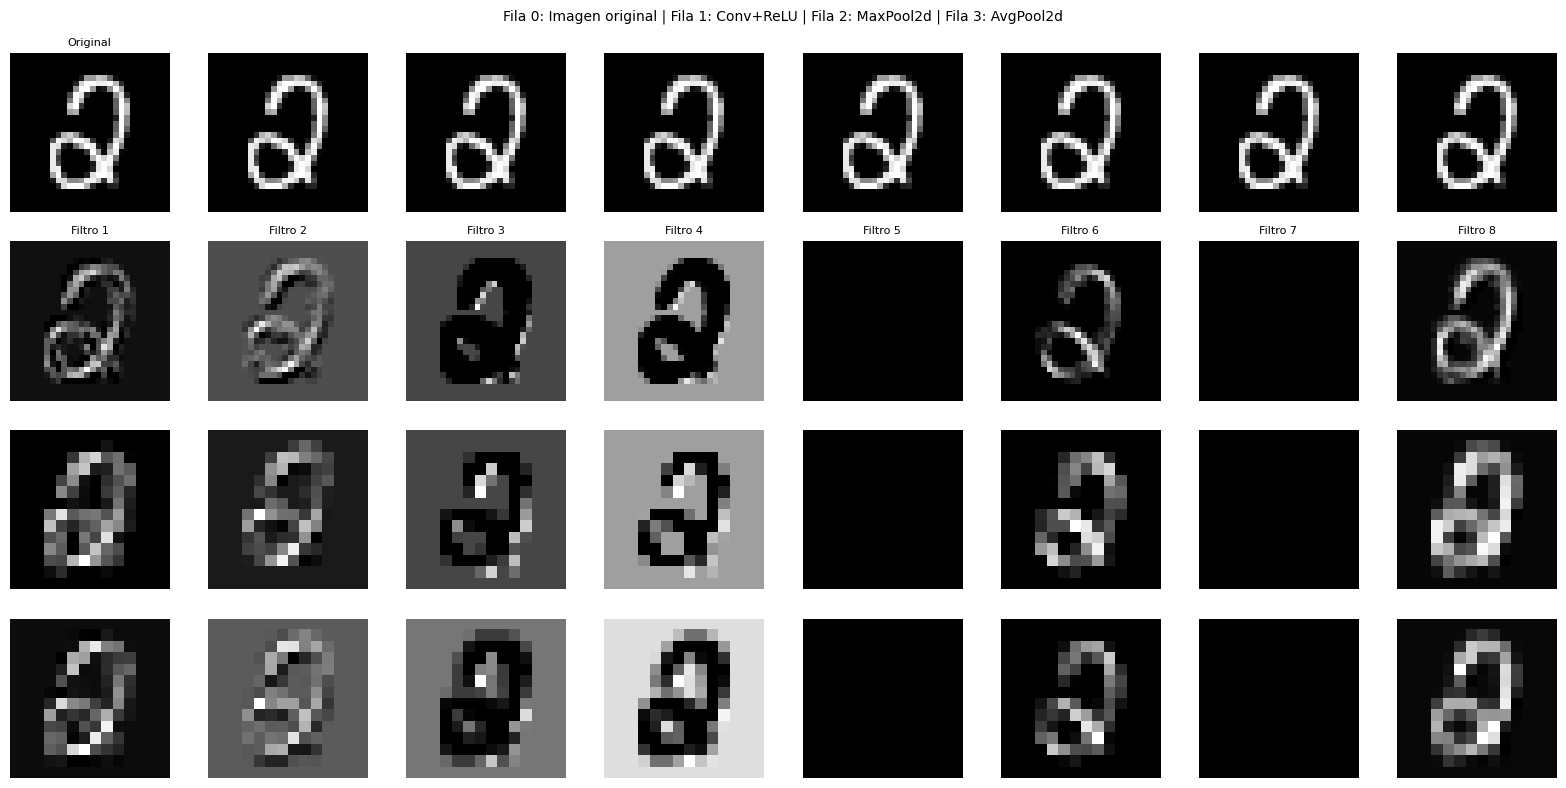

In [14]:
# ---------------------------------------------------
# Visualización: imagen original + Conv + MaxPool + AvgPool
# ---------------------------------------------------

img_idx = 0  # primera imagen del batch

img_original = images_cuda[img_idx].detach().cpu()     # (1, 28, 28)
acts_before  = x1[img_idx].detach().cpu()              # (8, 28, 28)
acts_max     = x2[img_idx].detach().cpu()              # (8, 14, 14)
acts_avg     = x3[img_idx].detach().cpu()              # (8, 14, 14)

# 4 filas (Original, Conv, MaxPool, AvgPool) × 8 columnas (filtros)
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(8):
    # Fila 0: Imagen original
    axes[0, i].imshow(img_original[0], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=8)

    # Fila 1: salida de Conv+ReLU
    axes[1, i].imshow(acts_before[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Filtro {i+1}', fontsize=8)

    # Fila 2: salida tras MaxPool
    axes[2, i].imshow(acts_max[i], cmap='gray')
    axes[2, i].axis('off')

    # Fila 3: salida tras AvgPool
    axes[3, i].imshow(acts_avg[i], cmap='gray')
    axes[3, i].axis('off')

plt.suptitle("Fila 0: Imagen original | Fila 1: Conv+ReLU | Fila 2: MaxPool2d | Fila 3: AvgPool2d", fontsize=10)
plt.tight_layout()
plt.show()


Como vemos, el pooling reduce el tamaño de la imagen, pero mantiene la información relevante.

Esta ténica esta dejando de usarse tanto porque:

- Elimina demasiada información, a veces destruyendo detalles importantes.
- Hace difícil entrenar redes profundas, porque el gradiente se propaga peor.
- Y su efecto (reducción espacial) se puede conseguir de forma más flexible con otras operaciones.


Veremos otras técnicas más adelante, de momento nos quedamos con esta tabla.

| Alternativa                      | Qué hace                                                                                | Ejemplo                            |
| -------------------------------- | --------------------------------------------------------------------------------------- | ---------------------------------- |
| **Stride en la convolución**     | En lugar de un MaxPool(2), se usa `Conv2d(..., stride=2)`; así la reducción se aprende. | ResNet, EfficientNet               |
| **Global Average Pooling (GAP)** | Sustituye el *flatten* final: promedia todo el mapa de activación por canal.            | Inception, MobileNet               |
| **Adaptive Pooling**             | Ajusta automáticamente el tamaño final, sin perder tanta información.                   | PyTorch `AdaptiveAvgPool2d((1,1))` |
| **Attention / Transformers**     | Dejan de usar pooling completamente y aprenden relaciones espaciales explícitas.        | ViT, ConvNext                      |


Concepto clave:

El pooling clásico fue un gran invento,
pero hoy se prefiere que la red aprenda la reducción espacial mediante convoluciones con stride o mecanismos adaptativos.